In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l2


In [11]:
train_directory = "C:/Users/gouth/OneDrive/Desktop/Alzheimer_s Dataset/train"
test_directory = "C:/Users/gouth/OneDrive/Desktop/Alzheimer_s Dataset/test"

# Creating empty lists to store images and labels from training and test directories
train_images = []
train_labels = []
test_images = []
test_labels = []

# Changing subdirectory names to integer labels
label_mapping = {'NonDemented': 0, 'VeryMildDemented': 1, 'MildDemented': 2, 'ModerateDemented': 3}

# loading images from a directory
def load_images_from_directory(directory, images_list, labels_list):
    for label_dir in os.listdir(directory):
        label_path = os.path.join(directory, label_dir)
        if os.path.isdir(label_path):
            label = label_mapping[label_dir]  
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                image = cv2.imread(image_path)  
                images_list.append(image)
                labels_list.append(label)

# Loading images and labels from the training directory
load_images_from_directory(train_directory, train_images, train_labels)

# Loading images and labels from the test directory
load_images_from_directory(test_directory, test_images, test_labels)

# Converting lists to numpy arrays
"""why do we convert lists to numpy arrays? because numpy arrays offer more efficient storage and operations for numerical data, making computations faster and more convenient, 
especially when dealing with large datasets and complex mathematical operations."""
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (5121, 208, 176, 3)
Train labels shape: (5121,)
Test images shape: (1279, 208, 176, 3)
Test labels shape: (1279,)


In [12]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_datagen.fit(train_images)

In [13]:
#resizing the images for input into the neural network model, ensuring consistent dimensions and compatibility with the network architecture.
train_images_resized = np.array([cv2.resize(img, (150, 150)) for img in train_images])
test_images_resized = np.array([cv2.resize(img, (150, 150)) for img in test_images])

In [22]:
# Combining all images and labels from training and testing folders into single arrays
all_images = np.concatenate((train_images_resized, test_images_resized), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Spliting  the combined data into training and testing sets
train_images_final, test_images_final, train_labels_final, test_labels_final = train_test_split(all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

print("Final Train images shape:", train_images_final.shape)
print("Final Train labels shape:", train_labels_final.shape)
print("Final Test images shape:", test_images_final.shape)
print("Final Test labels shape:", test_labels_final.shape)


Final Train images shape: (5120, 150, 150, 3)
Final Train labels shape: (5120,)
Final Test images shape: (1280, 150, 150, 3)
Final Test labels shape: (1280,)


At the end of the notebook i tuned the model and used the best model below.

In [27]:
model_architecture_3 = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.2),
        Dense(4, activation='softmax')
    ])
model_architecture_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_architecture_3.fit(train_images_final, train_labels_final, epochs=100, validation_data=(test_images_final, test_labels_final), batch_size=32)

Epoch 1/100
160/160 [==============================] - 23s 144ms/step - loss: 235.4746 - accuracy: 0.5160 - val_loss: 0.8768 - val_accuracy: 0.6687
Epoch 2/100
160/160 [==============================] - 23s 144ms/step - loss: 0.8297 - accuracy: 0.6764 - val_loss: 0.8370 - val_accuracy: 0.6477
Epoch 3/100
160/160 [==============================] - 23s 144ms/step - loss: 0.6660 - accuracy: 0.7449 - val_loss: 0.6153 - val_accuracy: 0.7586
Epoch 4/100
160/160 [==============================] - 23s 144ms/step - loss: 0.5707 - accuracy: 0.7867 - val_loss: 0.6034 - val_accuracy: 0.7805
Epoch 5/100
160/160 [==============================] - 23s 145ms/step - loss: 0.4232 - accuracy: 0.8604 - val_loss: 0.4946 - val_accuracy: 0.8258
Epoch 6/100
160/160 [==============================] - 23s 146ms/step - loss: 0.3107 - accuracy: 0.9002 - val_loss: 0.3841 - val_accuracy: 0.8813
Epoch 7/100
160/160 [==============================] - 23s 145ms/step - loss: 0.2618 - accuracy: 0.9285 - val_loss: 0.2902

In [30]:
training_accuracy = np.array(history.history['accuracy'])
testing_accuracy = np.array(history.history['val_accuracy'])

best_epoch = np.argmax(training_accuracy)
best_training_accuracy = training_accuracy[best_epoch]
best_testing_accuracy = testing_accuracy[best_epoch]

print("Best Epoch:", best_epoch + 1)
print("Best Training Accuracy:", best_training_accuracy)
print("Testing Accuracy:", best_testing_accuracy)

Best Epoch: 55
Best Training Accuracy: 0.990429699420929
Testing Accuracy: 0.977343738079071


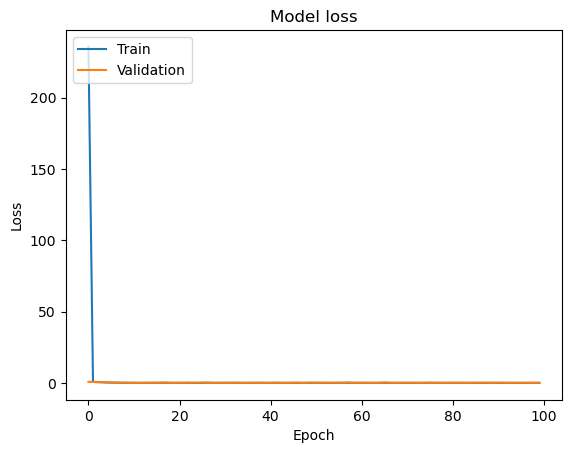

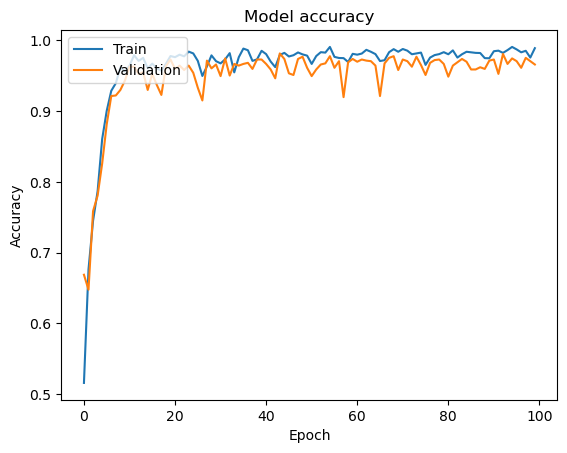

In [29]:
# Training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [77]:
def create_model(dropout_rate=0.2, optimizer='adam', l2_reg=0.01):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

# hyperparameters grid
param_grid = {
    'epochs': [20, 30, 50, 100],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop'],
    'l2_reg': [0.1, 0.01, 0.001, 0.0001]
}

# Performming grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(train_images_final, train_labels_final)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


C:\Users\gouth\AppData\Local\Temp\ipykernel_15884\3867639288.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)


Best: 0.930862 using {'dropout_rate': 0.2, 'epochs': 100, 'l2_reg': 0.0001, 'optimizer': 'adam'}
0.719339 (0.012880) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.1, 'optimizer': 'adam'}
0.587308 (0.012011) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.1, 'optimizer': 'rmsprop'}
0.880081 (0.018424) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.01, 'optimizer': 'adam'}
0.676560 (0.044172) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.01, 'optimizer': 'rmsprop'}
0.910350 (0.007545) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.001, 'optimizer': 'adam'}
0.791951 (0.149291) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.001, 'optimizer': 'rmsprop'}
0.736343 (0.175094) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.0001, 'optimizer': 'adam'}
0.870126 (0.049265) with: {'dropout_rate': 0.2, 'epochs': 20, 'l2_reg': 0.0001, 'optimizer': 'rmsprop'}
0.803896 (0.038955) with: {'dropout_rate': 0.2, 'epochs': 30, 'l2_reg': 0.1, 'optimizer': 'adam